In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import string
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
df = pd.read_csv('Combined Data.csv',index_col = 0)
df1 = df.copy() 
df1.dropna(inplace = True)
df1.head()


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [11]:
df.head(20)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
5,"every break, you must be nervous, like somethi...",Anxiety
6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,Have you ever felt nervous but didn't know why?,Anxiety
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,"I'm really worried, I want to cry.",Anxiety


<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   statement      52681 non-null  object
 1   status         52681 non-null  object
 2   statement_len  52681 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB
None


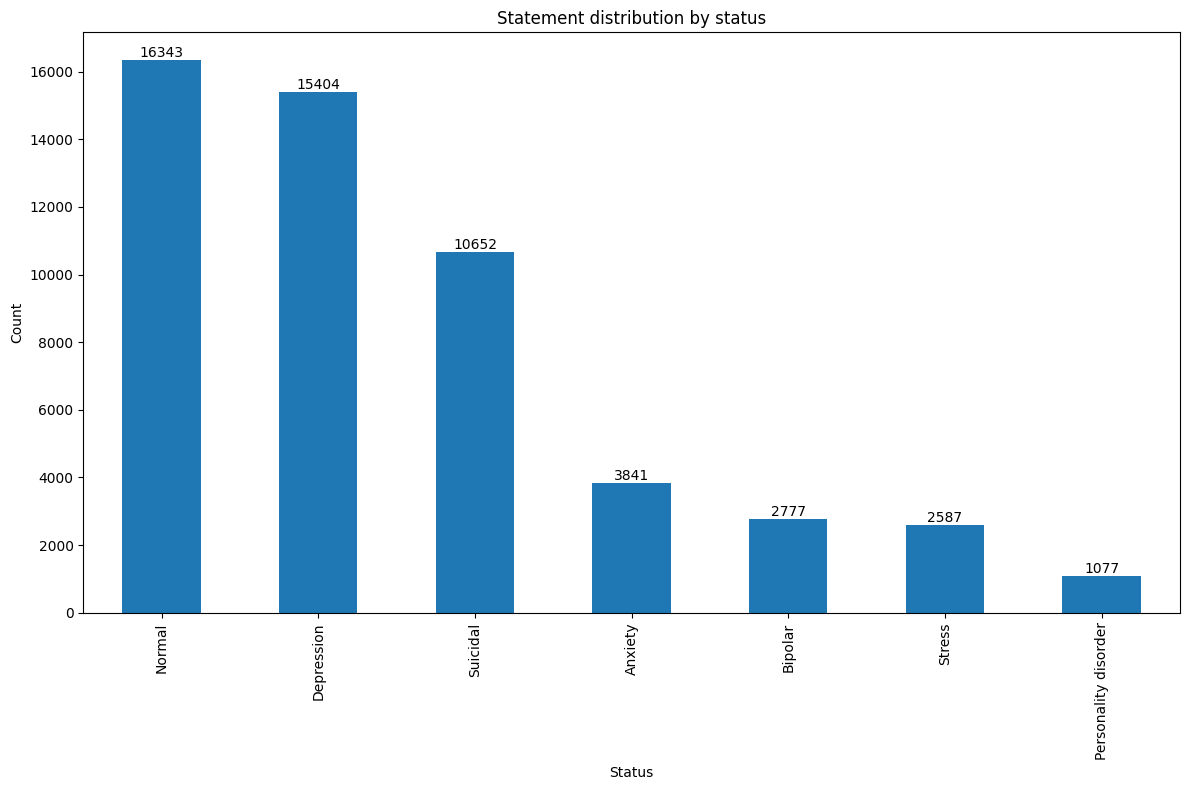

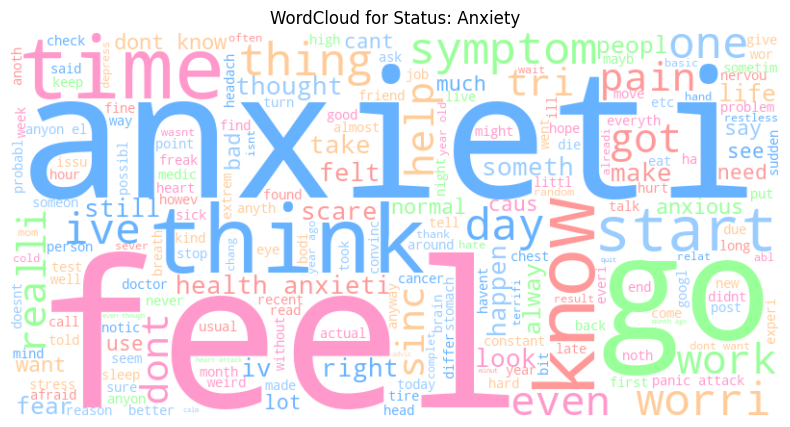

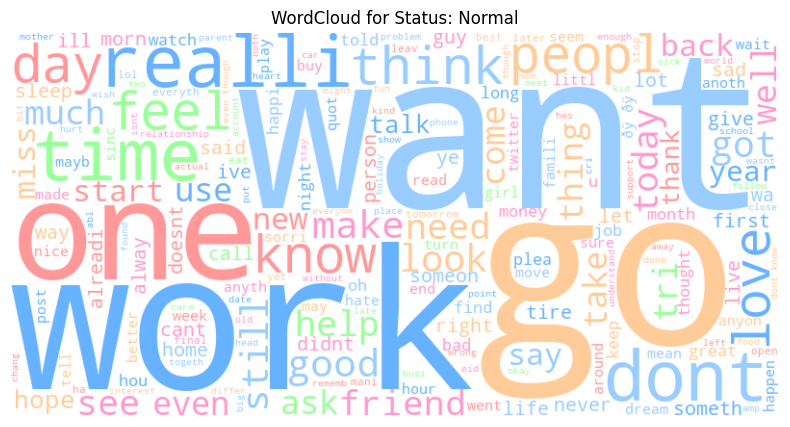

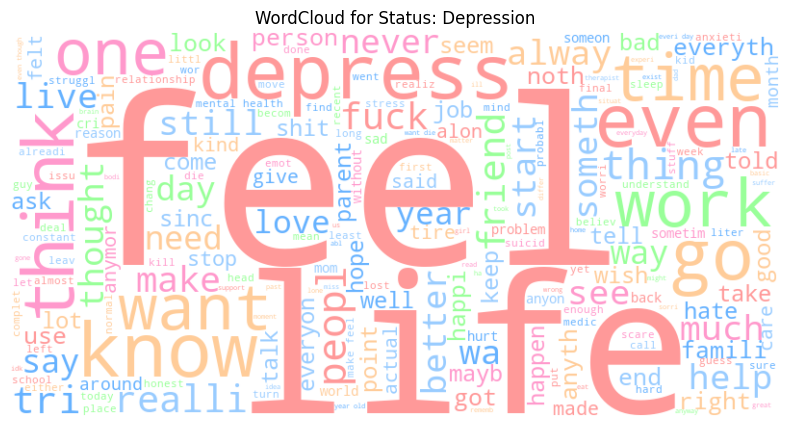

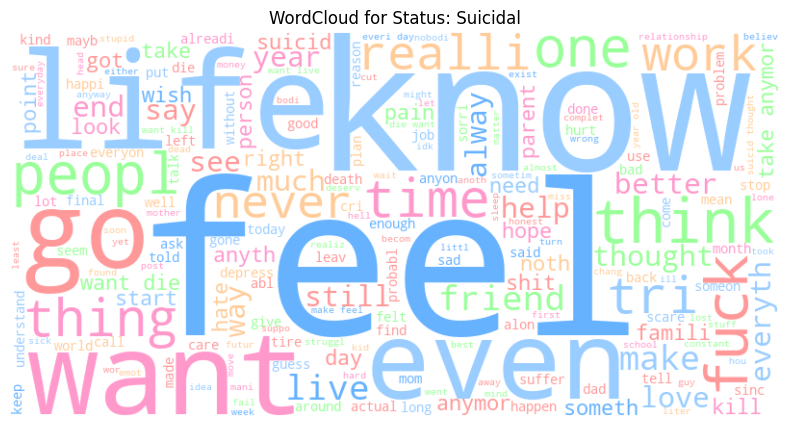

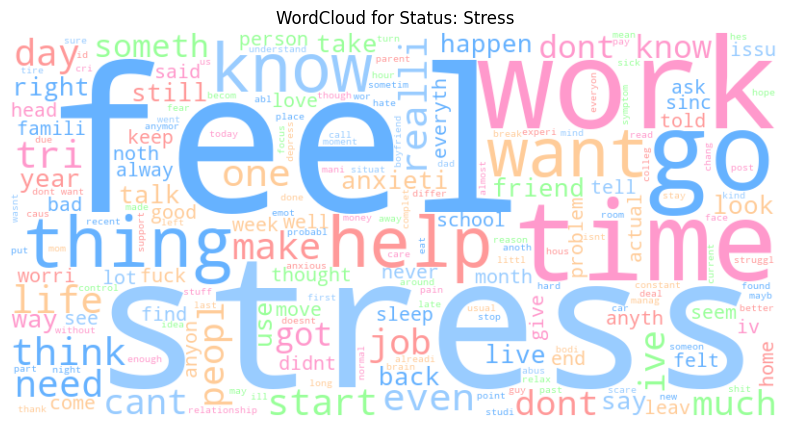

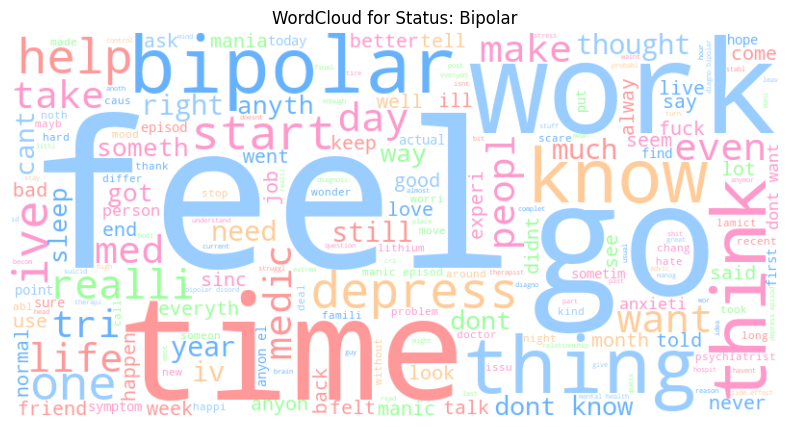

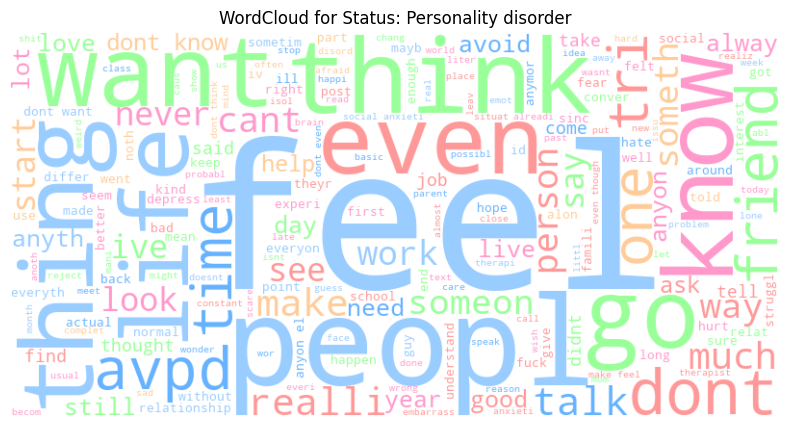

52681 52681
47412 47412
5269 5269
(102816, 50000) (102816,)


In [5]:
df1.shape

df1['statement_len'] = df1['statement'].apply(lambda x: len(x.split(' ')))
df1.head()

print(df1.info())

df1.describe(include='object').T

plt.figure(figsize=(12,8))

# get the unique status values and their counts
status_counts = df1['status'].value_counts()

# create the bar plot
ax = status_counts.plot(kind='bar')

# add the count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Data Pre-processing
# Now we are going to engineering the data to make it easier for the model to clasiffy.

# This section is very important to reduce the dimensions of the problem.

# Cleaning the corpus

def clean_text(text):
    '''
    Comprehensively clean text by making it lowercase, removing various patterns,
    links, punctuation, and words containing numbers.
    '''
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove URLs (including markdown-style links)
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    
    # Remove punctuation and other special characters
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()
df2 = df1.copy()

df2['statement_clean'] = df2['statement'].apply(clean_text)
df2.head()

"""
Stopwords are commonly used words in English which have no contextual meaning in a sentence. Examples of stopwords include:

Articles: a, an, the
Prepositions: in, on, at, to, for, of, with
Pronouns: I, you, he, she, it, we, they, them
Conjunctions: and, but, or, so, because
Auxiliary verbs: is, am, are, was, were, be, been, have, has, had
Common adverbs: very, really, too, also, just
Common adjectives: many, much, few, more, most, some, any
Others: this, that, these, those, there, here


"""

stop_words = stopwords.words('english') 
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df2['statement_clean'] = df2['statement_clean'].apply(remove_stopwords)
df2.head(2)

"""
Stemming/ Lematization

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal 
correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and
dictionary form of a word. As far as the meaning of the words is important for this study, we are meant to focus on lemmatization rather than stemming,
but for its simplicity we will use stemming
"""

stemmer = nltk.SnowballStemmer("english")
# stemmer = nltk.PorterStemmer()

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df2['statement_clean'] = df2['statement_clean'].apply(stemm_text) 
df2.head()


# All together 

def preprocess_data(text):
    #Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

df2['statement_clean'] = df2['statement_clean'].apply(preprocess_data)
df2.head()

# Target Encoding
from sklearn.preprocessing import LabelEncoder

l_encoder = LabelEncoder()
l_encoder.fit(df2['status'])

df2['status_encoded'] = l_encoder.transform(df2['status']) 
df2.head()

# Tokens Visualization
df2['tokens'] = df2['statement_clean'].apply(word_tokenize)
df2.columns


# Get unique categories in 'status'
statuses = df2['status'].unique()

# Define a list of colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF']

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df2[df2['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()


"""
Vectorization
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

Count how many times does a word occur in each message (Known as term frequency)
Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
Normalize the vectors to unit length, to abstract from the original text length (L2 norm)
"""

# define X and y for use with COUNTVECTORIZER
X = df2['statement_clean']
y = df2['status_encoded']

print(len(X), len(y))

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

# instantiate the vectorizer
c_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.7, max_features=50_000)
c_vectorizer.fit(X_train)

# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = c_vectorizer.transform(X_train)
X_test_dtm = c_vectorizer.transform(X_test)

texts = df2['statement_clean']
target = df2['status_encoded'] 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

# Addressing Class Imbalance
r_oversampler = RandomOverSampler(random_state= 42) 
X_train_resampled, y_train_resampled = r_oversampler.fit_resample(X_train_dtm, y_train)

print((X_train_resampled.shape), (y_train_resampled.shape))


In [ ]:
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df2[df2['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

                      precision    recall  f1-score   support

             Anxiety       0.81      0.83      0.82       371
             Bipolar       0.83      0.82      0.83       273
          Depression       0.71      0.68      0.70      1521
              Normal       0.89      0.94      0.92      1655
Personality disorder       0.77      0.68      0.73       114
              Stress       0.66      0.58      0.62       258
            Suicidal       0.63      0.64      0.64      1077

            accuracy                           0.77      5269
           macro avg       0.76      0.74      0.75      5269
        weighted avg       0.76      0.77      0.77      5269



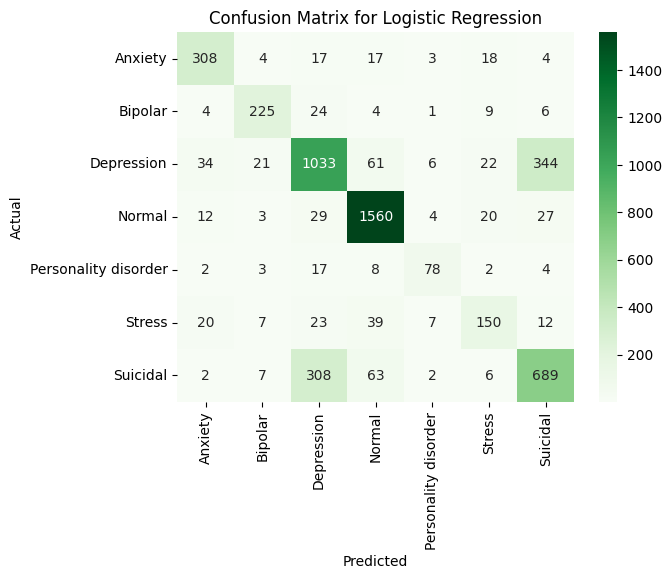

                      precision    recall  f1-score   support

             Anxiety       0.85      0.78      0.82       371
             Bipolar       0.95      0.69      0.80       273
          Depression       0.65      0.72      0.69      1521
              Normal       0.79      0.95      0.87      1655
Personality disorder       1.00      0.43      0.60       114
              Stress       1.00      0.29      0.46       258
            Suicidal       0.66      0.57      0.61      1077

            accuracy                           0.74      5269
           macro avg       0.84      0.64      0.69      5269
        weighted avg       0.75      0.74      0.73      5269



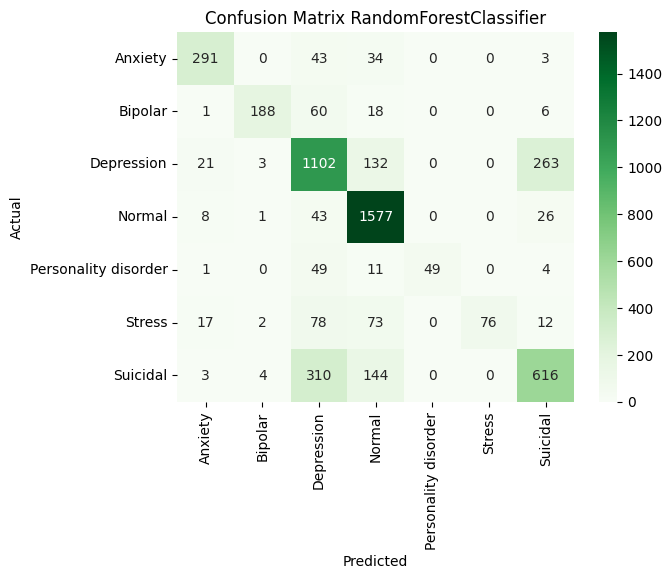

In [6]:
# Modelling 

# Logistic
lr_clf = LogisticRegression(random_state= 42) 

# Train the classifier
lr_clf.fit(X_train_resampled, y_train_resampled)
y_pred = lr_clf.predict(X_test_dtm)
labels = l_encoder.classes_
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


# Random Forest Classifier

rf_clf = RandomForestClassifier(random_state=42, n_estimators=500)
rf_clf.fit(X_train_resampled, y_train_resampled)
y_pred2 = rf_clf.predict(X_test_dtm)
labels = l_encoder.classes_
conf_matrix2 = confusion_matrix(y_test, y_pred2)
print(classification_report(y_test, y_pred2, target_names=labels))

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix RandomForestClassifier')
plt.show()

# # Extreme Gradient Boosting AKA XGBoost

# # xgb_clf = XGBClassifier(n_estimators= 1_000, learning_rate=0.05, tree_method='gpu_hist') 
# # xgb_clf.fit(X_train_resampled, y_train_resampled, 
# #              early_stopping_rounds=5, 
# #              eval_set=[(X_test_dtm, y_test)], 
# #              verbose=False)
# xgb_clf = XGBClassifier(n_estimators=300, learning_rate=0.05, tree_method='gpu_hist', n_jobs=-1)
# xgb_clf.fit(
#     X_train_resampled, y_train_resampled, 
#     early_stopping_rounds=5, 
#     eval_set=[(X_test_dtm, y_test)], 
#     verbose=True
# )


# y_pred3 = xgb_clf.predict(X_test_dtm)

# labels3 = l_encoder.classes_
# conf_matrix3 = confusion_matrix(y_test, y_pred3)
# print(classification_report(y_test, y_pred3, target_names=labels3))

# sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels3)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix XGBClassifier')
# plt.show()

                      precision    recall  f1-score   support

             Anxiety       0.74      0.80      0.77       371
             Bipolar       0.70      0.79      0.74       273
          Depression       0.67      0.67      0.67      1521
              Normal       0.90      0.93      0.91      1655
Personality disorder       0.72      0.59      0.65       114
              Stress       0.64      0.55      0.59       258
            Suicidal       0.63      0.59      0.60      1077

            accuracy                           0.74      5269
           macro avg       0.71      0.70      0.70      5269
        weighted avg       0.74      0.74      0.74      5269



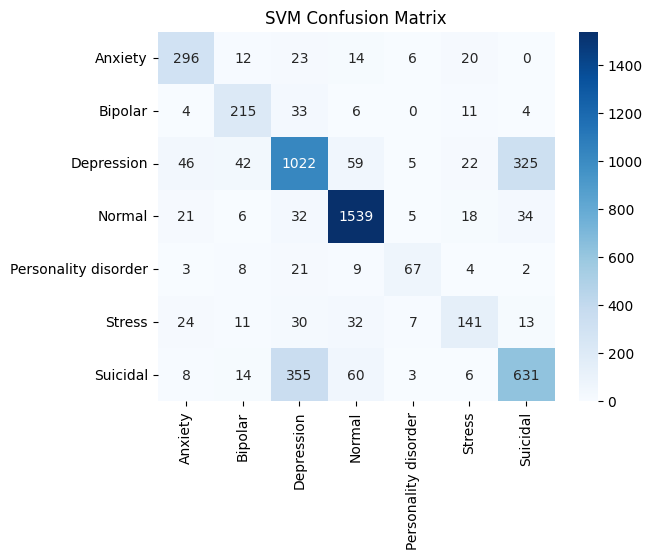

In [8]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_clf.predict(X_test_dtm)
print(classification_report(y_test, y_pred_svm, target_names=labels))

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('SVM Confusion Matrix')
plt.show()


                      precision    recall  f1-score   support

             Anxiety       0.50      0.82      0.62       371
             Bipolar       0.52      0.81      0.63       273
          Depression       0.67      0.57      0.62      1521
              Normal       0.89      0.54      0.67      1655
Personality disorder       0.26      0.68      0.38       114
              Stress       0.42      0.53      0.47       258
            Suicidal       0.59      0.73      0.65      1077

            accuracy                           0.62      5269
           macro avg       0.55      0.67      0.58      5269
        weighted avg       0.68      0.62      0.63      5269



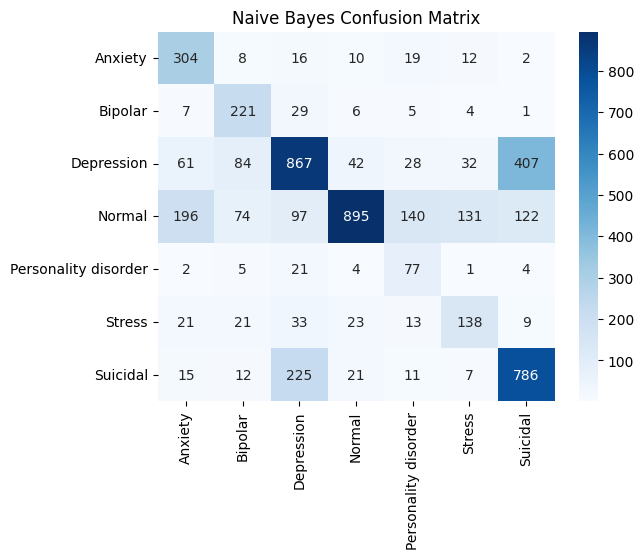

In [9]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train_resampled, y_train_resampled)
y_pred_nb = nb_clf.predict(X_test_dtm)
print(classification_report(y_test, y_pred_nb, target_names=labels))

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Naive Bayes Confusion Matrix')
plt.show()


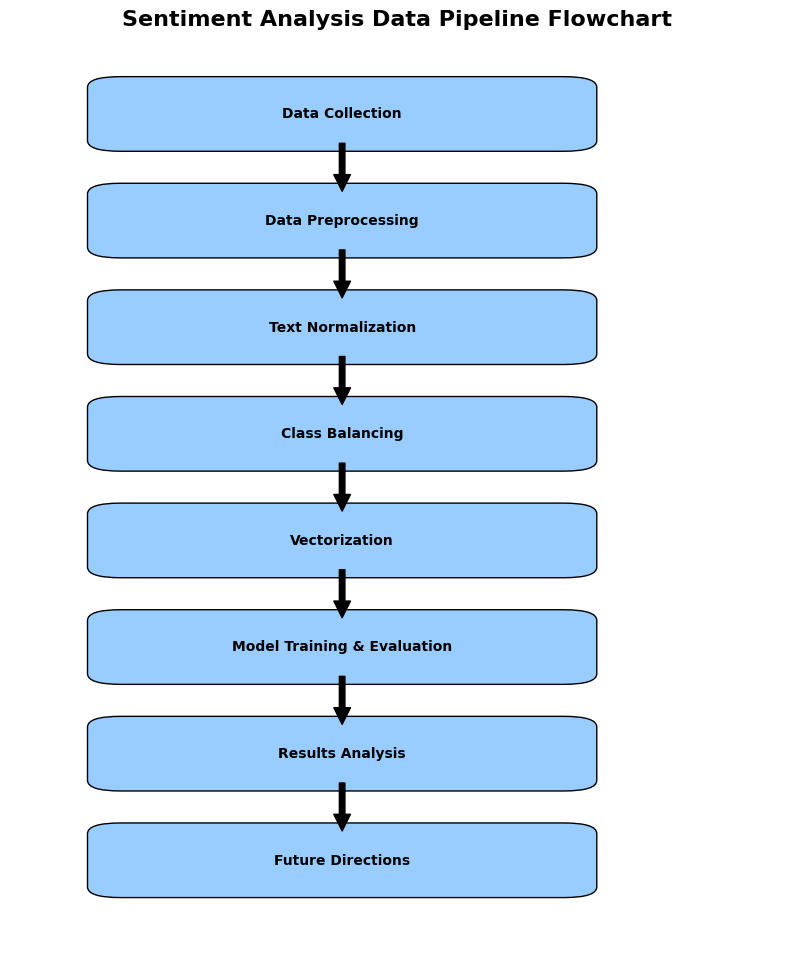

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Create a flowchart representation using Matplotlib to show data pipeline
fig, ax = plt.subplots(figsize=(10, 12))

# Function to draw boxes with arrows between them
def draw_box(ax, text, xy, boxstyle="round,pad=0.3", box_color="#99CCFF"):
    box = FancyBboxPatch(xy, width=4, height=1.5, boxstyle=boxstyle, ec="black", fc=box_color)
    ax.add_patch(box)
    ax.text(xy[0] + 2, xy[1] + 0.75, text, ha="center", va="center", fontsize=10, weight="bold")

# Draw boxes for each step in the pipeline
steps = [
    ("Data Collection", (0, 15)),
    ("Data Preprocessing", (0, 12)),
    ("Text Normalization", (0, 9)),
    ("Class Balancing", (0, 6)),
    ("Vectorization", (0, 3)),
    ("Model Training & Evaluation", (0, 0)),
    ("Results Analysis", (0, -3)),
    ("Future Directions", (0, -6))
]

for step in steps:
    draw_box(ax, step[0], step[1])

# Draw arrows between steps
for i in range(len(steps) - 1):
    ax.annotate("", xy=(2, steps[i + 1][1][1] + 1.5), xytext=(2, steps[i][1][1]),
                arrowprops=dict(facecolor='black', shrink=0.05))

# Set limits and remove axes for a clean look
ax.set_xlim(-1, 6)
ax.set_ylim(-8, 18)
ax.axis('off')

# Display the flowchart
plt.title('Sentiment Analysis Data Pipeline Flowchart', fontsize=16, weight='bold')
plt.show()


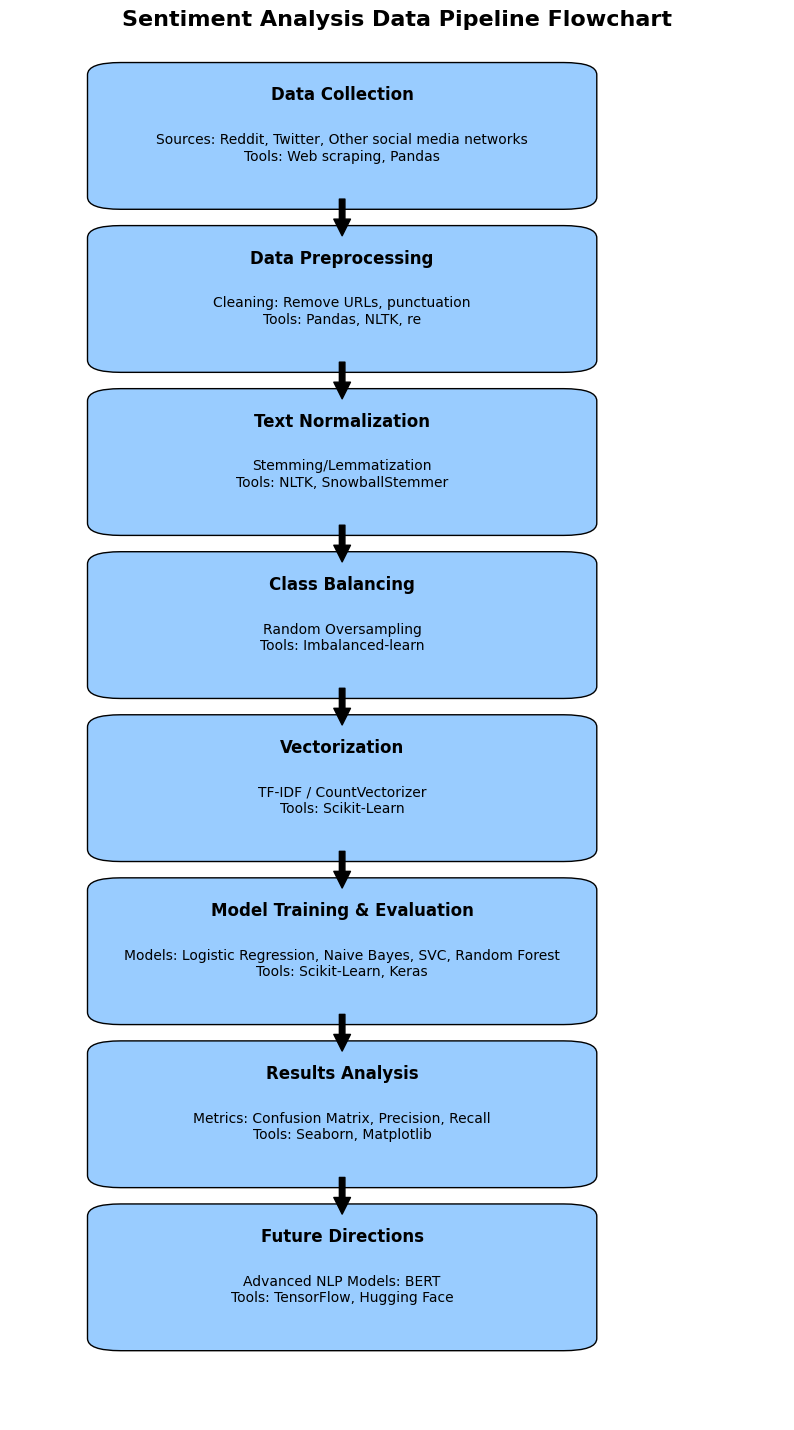

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Create a flowchart representation using Matplotlib to show data pipeline
fig, ax = plt.subplots(figsize=(10, 18))

# Function to draw boxes with arrows between them and add details
def draw_box(ax, title, details, xy, boxstyle="round,pad=0.3", box_color="#99CCFF"):
    # Draw main box
    box = FancyBboxPatch(xy, width=4, height=3, boxstyle=boxstyle, ec="black", fc=box_color)
    ax.add_patch(box)
    # Add title
    ax.text(xy[0] + 2, xy[1] + 2.5, title, ha="center", va="center", fontsize=12, weight="bold")
    # Add details
    ax.text(xy[0] + 2, xy[1] + 1.2, details, ha="center", va="center", fontsize=10)

# Define each step with tools and sources
steps = [
    ("Data Collection", "Sources: Reddit, Twitter, Other social media networks\nTools: Web scraping, Pandas", (0, 18)),
    ("Data Preprocessing", "Cleaning: Remove URLs, punctuation\nTools: Pandas, NLTK, re", (0, 14)),
    ("Text Normalization", "Stemming/Lemmatization\nTools: NLTK, SnowballStemmer", (0, 10)),
    ("Class Balancing", "Random Oversampling\nTools: Imbalanced-learn", (0, 6)),
    ("Vectorization", "TF-IDF / CountVectorizer\nTools: Scikit-Learn", (0, 2)),
    ("Model Training & Evaluation", "Models: Logistic Regression, Naive Bayes, SVC, Random Forest\nTools: Scikit-Learn, Keras", (0, -2)),
    ("Results Analysis", "Metrics: Confusion Matrix, Precision, Recall\nTools: Seaborn, Matplotlib", (0, -6)),
    ("Future Directions", "Advanced NLP Models: BERT\nTools: TensorFlow, Hugging Face", (0, -10))
]

# Draw each box for the steps
for step in steps:
    draw_box(ax, step[0], step[1], step[2])

# Draw arrows between steps
for i in range(len(steps) - 1):
    ax.annotate("", xy=(2, steps[i + 1][2][1] + 3), xytext=(2, steps[i][2][1]),
                arrowprops=dict(facecolor='black', shrink=0.05))

# Set limits and remove axes for a clean look
ax.set_xlim(-1, 6)
ax.set_ylim(-12, 22)
ax.axis('off')

# Display the flowchart
plt.title('Sentiment Analysis Data Pipeline Flowchart', fontsize=16, weight='bold')
plt.show()


1.98